In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

COLUMN_WIDTH = 3.25  # Inches
TEXT_WIDTH = 6.299213  # Inches
GOLDEN_RATIO = 1.61803398875
DPI = 300
FONT_SIZE = 8

mpl.rcParams['font.size'] = FONT_SIZE
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times']
# mpl.rcParams['text.usetex'] = True

mpl.rcParams['text.usetex'] = False
from bbutils import BetaBernoulli
num_classes = 10

In [2]:
predictions = np.genfromtxt("data/svhn/svhn_predictions.txt", delimiter=' ', dtype = float)
df = pd.DataFrame(predictions[:,0].astype(int), columns=['Correct'])
df['Predicted'] = np.argmax(predictions[:,1:11], axis=1)
df['Confidence'] = np.max(predictions[:,1:11], axis=1)
df = df.reset_index()
num_classes = 10
confidence_k = np.array([df[(df['Predicted']==id)]['Confidence'].mean() 
                 for id in range(num_classes)])
print(confidence_k)

[0.97773569 0.98101865 0.98067139 0.97239445 0.98474999 0.98067443
 0.97458461 0.97530219 0.97426378 0.97472244]


In [3]:
df.shape

(26032, 4)

In [4]:
# get value for the varaibles robby defined
category2idx = {i:i for i in range(num_classes)}
idx2category = {i:i for i in range(num_classes)}
categories = df['Predicted'].tolist()
observations = [df['Predicted'][idx] == df['Correct'][idx] for idx in range(df.shape[0])] 

In [5]:
# Try to identify worst class
n = df.shape[0]
k = num_classes
runs = 100
mode = 'max'

active_choices = np.zeros((runs, k, n))
active_thetas = np.zeros((runs, k, n))
random_thetas = np.zeros((runs, k, n))

for r in range(runs):

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Random model
    model = BetaBernoulli(k)

#     # Prior
#     # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0
    for i in range(n):
        while True:
            category = random.randrange(k)
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        random_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
    
    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Beta Bernoulli model
    model = BetaBernoulli(k)

    # Prior
    # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0

    for i in range(n):
        theta_hat = model.sample()
        bias = confidence_k - theta_hat
        
        if mode == 'max':
            choices = np.argsort(bias)[::-1]
        elif mode == 'min':
            choices = np.argsort(bias)
            
        for j in range(k):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        
        active_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
        if i > 0:
            active_choices[r, :, i] = active_choices[r, :, i - 1]
        active_choices[r, category, i] += 1

In [6]:
correct = np.zeros(k)
total = np.zeros(k)

for category, observation in zip(categories, observations):
    if observation:
        correct[category] += 1
    total[category] += 1
    
empirical_acc = correct / total
empirical_bias = confidence_k - empirical_acc
ranked = np.argsort(empirical_bias)[::-1]

In [7]:
for i in range(9):
    idx = ranked[i]
    print(idx2category[idx], empirical_bias[idx])

9 0.02290032426806554
3 0.015216493397684272
1 0.01484814625362385
0 0.01353114510227249
5 0.012400316302876635
6 0.010552186443769318
4 0.010451845808618687
8 0.005513775582933089
7 0.002602494726997695


1
2
3
4
5
7
6
0
8
9


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


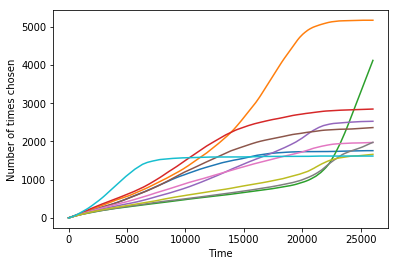

In [8]:
avg_active_choices = np.mean(active_choices, axis=0)

for i in range(k):
    plt.plot(avg_active_choices[i,:])
    plt.xlabel('Time')
    plt.ylabel('Number of times chosen')

top = np.argsort(avg_active_choices[:,-1])[::-1]

for i in top[:10]:
    print(idx2category[i])

In [9]:
most_chosen = np.argmax(active_choices[:, :, :], axis=1)

cutoff = 9

if mode == 'max':
    selection = ranked[:cutoff]
elif mode == 'min':
    selection = ranked[-cutoff:]
    selection = selection[::-1]
    
timestamps = [100, 200, 300, 400, 500]

table = np.zeros((cutoff+1, len(timestamps)))
    
for i, category in enumerate(selection):
    for j, timestamp in enumerate(timestamps):
        table[i,j] = np.mean(most_chosen[:,timestamp] == category)

table[cutoff,:] = 1 - np.sum(table, axis=0)

In [23]:
header = ' ' * 10 + ' '.join('%6i' % x for x in timestamps)
print(header)

for i, row in enumerate(table):
    if i < cutoff:
        category = idx2category[selection[i]]
    else:
        category = 'OTHER'
    category_string = '{}         '.format(category)
    num_string = ' '.join('{:.04f}'.format(x) for x in row.tolist())
    print(category_string + num_string)

             100    200    300    400    500
9         0.0700 0.1200 0.1200 0.1600 0.1800
3         0.1700 0.2300 0.1600 0.1500 0.1800
1         0.1800 0.1900 0.1700 0.1500 0.1500
0         0.0400 0.0900 0.1100 0.0900 0.0800
5         0.0700 0.0900 0.1500 0.1200 0.1300
6         0.0900 0.0800 0.0800 0.1200 0.1200
4         0.0800 0.0500 0.0500 0.0300 0.0300
8         0.0900 0.0400 0.0400 0.0400 0.0300
7         0.0900 0.0700 0.0800 0.0800 0.0300
OTHER         0.1200 0.0400 0.0400 0.0600 0.0700


In [24]:
confidence_k = confidence_k.reshape(1, -1 , 1)
if mode == 'max':
    random_success = np.mean(np.argmax(confidence_k - random_thetas, axis=1) == selection[0], axis=0)
    active_success = np.mean(np.argmax(confidence_k - active_thetas, axis=1) == selection[0], axis=0)
elif mode == 'min':
    random_success = np.mean(np.argmin(confidence_k - random_thetas, axis=1) == selection[0], axis=0)
    active_success = np.mean(np.argmin(confidence_k - active_thetas, axis=1) == selection[0], axis=0)

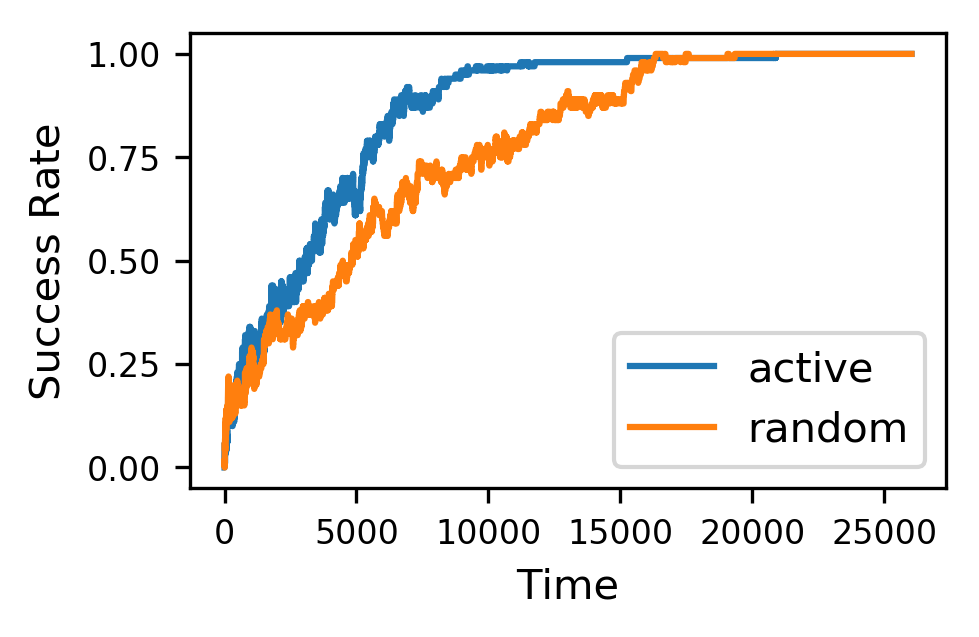

In [25]:
# If labels are getting cut off make the figsize smaller
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH / GOLDEN_RATIO), dpi=300)

plt.plot(active_success, label='active')
plt.plot(random_success, label='random')
plt.xlabel('Time')
plt.ylabel('Success Rate')
plt.legend()

# FORMAT STUFF ##
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)


plt.savefig("figures/active_svhn_calibration_bias_%s_runs_%d.pdf" % (mode, runs), format='pdf')
np.save('output/active_svhn_calibration_bias_%s_runs_%d_active_success' % (mode, runs), active_success)
np.save('output/active_svhn_calibration_bias_%s_runs_%d_random_success' % (mode, runs), random_success)